In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Alex Mallen (atmallen@uw.edu)
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import time

from dpk import model_objs

seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# generate toy data with periodic uncertainty
T = 20_000
t = np.linspace(0, 100 * np.pi, T)
mu_t = (1.2 + np.sin(-t) + np.cos(4 * t))
# sigma_t = 0.1 * (2 + 0.7 * np.sin(t)) ** 2
sigma_t = 0.3 * np.cos(t) + 0.8
data = np.random.normal(mu_t, sigma_t)
# normalize the data
scale = np.std(data)
loc = np.mean(data)
x = (data - loc) / scale
x = torch.Tensor(x.reshape(-1, 1))

periods = [200.0, 50.0]
omegas = [2 * np.pi / p for p in periods]
omega_dim = len(omegas)
# define a model
l1width = 1024
l2width = 1024
wd = 1e-3
lrt = 1e-3
model_obj = model_objs.NormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=l1width, n2=l2width)
# model_obj = model_objs.SkewNormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=l1width, n2=l2width)
# model_obj = model_objs.DeterministicMSE(x_dim=x.shape[1], num_freqs=len(periods), n=l1width, n2=l2width)

[ Using Seed :  633  ]


In [14]:
K = 10  # number of points within a period of the error surface to use
two_pi_linspace = torch.arange(0, K) * 2 * np.pi / K
two_pi_linspaces = torch.meshgrid(*((two_pi_linspace,) * omega_dim), indexing="ij")
flatteneds = [l.reshape(l.numel()) for l in two_pi_linspaces]
two_pi_block = torch.stack(flatteneds).T
two_pi_block

tensor([[0.0000, 0.0000],
        [0.0000, 0.6283],
        [0.0000, 1.2566],
        [0.0000, 1.8850],
        [0.0000, 2.5133],
        [0.0000, 3.1416],
        [0.0000, 3.7699],
        [0.0000, 4.3982],
        [0.0000, 5.0265],
        [0.0000, 5.6549],
        [0.6283, 0.0000],
        [0.6283, 0.6283],
        [0.6283, 1.2566],
        [0.6283, 1.8850],
        [0.6283, 2.5133],
        [0.6283, 3.1416],
        [0.6283, 3.7699],
        [0.6283, 4.3982],
        [0.6283, 5.0265],
        [0.6283, 5.6549],
        [1.2566, 0.0000],
        [1.2566, 0.6283],
        [1.2566, 1.2566],
        [1.2566, 1.8850],
        [1.2566, 2.5133],
        [1.2566, 3.1416],
        [1.2566, 3.7699],
        [1.2566, 4.3982],
        [1.2566, 5.0265],
        [1.2566, 5.6549],
        [1.8850, 0.0000],
        [1.8850, 0.6283],
        [1.8850, 1.2566],
        [1.8850, 1.8850],
        [1.8850, 2.5133],
        [1.8850, 3.1416],
        [1.8850, 3.7699],
        [1.8850, 4.3982],
        [1.8

In [15]:
norm = torch.distributions.normal.Normal(0, 1)
def norm_logcdf(z):

        if (z < -7).any():  # these result in NaNs otherwise
            # print("THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)")
            # https://stats.stackexchange.com/questions/106003/approximation-of-logarithm-of-standard-normal-cdf-for-x0/107548#107548?newreg=5e5f6365aa7046aba1c447e8ae263fec
            # I found this approx to be good: less than 0.04 error for all -20 < x < -5
            # approx = lambda x: -0.5 * x ** 2 - 4.8 + 2509 * (x - 13) / ((x - 40) ** 2 * (x - 5))
            ans = torch.where(z < -0.1, -0.5 * z ** 2 - 4.8 + 2509 * (z - 13) / ((z - 40) ** 2 * (z - 5)),
                                        -torch.exp(-z * 2) / 2 - torch.exp(-(z - 0.2) ** 2) * 0.2)
        else:
            ans = norm.cdf(z).log()

        return ans

In [16]:
from torch import optim
from torch.fft import fftn, ifftn, fftfreq

In [17]:
inpts = torch.cat([torch.cos(two_pi_block)] * 2 + [torch.sin(two_pi_block)] * 2, -1)  # .to("dml")
#     inpts = torch.cat([torch.cos(two_pi_block)] + [torch.sin(two_pi_block)], -1)
#     inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)
inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
inpts.shape  #  (K**omega_dim, omega_dim * 2 * num_params)

torch.Size([100, 8])

In [18]:
opt = optim.SGD(model_obj.parameters(), lr=3e-3)

num_epochs = 100
train_losses = []
times = []
# find frequency associated with each element of Lft
freqs = fftfreq(K) / T
F = torch.meshgrid(*(freqs for _ in range(omega_dim)))
t_vec = torch.arange(1, T + 1).reshape((T,) + (1,) * omega_dim)
F = [f.reshape((1,) + f.shape) * t_vec for f in F]
start_time = time.time()
# train the model
for itr in range(num_epochs):
    opt.zero_grad()
    
    losses = torch.empty((T, K**omega_dim))
    print("1:", time.time() - start_time)
    m, s = model_obj.decode(inpts)
    print("2:", time.time() - start_time)
    m, s = m.squeeze(), s.squeeze()
#     y, z, a = model_obj.decode(inpts)
#     xhat, = model_obj.decode(inpts)
    losses = ((x - m) ** 2 / (2 * s ** 2) + torch.log(s)).squeeze()
    # for tt in range(T):
    #     losses[tt, :] = ((x[tt, :] - m) ** 2 / (2 * s ** 2) + torch.log(s)).squeeze()
#         losses[tt, :] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
#         losses[tt, :] = (xhat.squeeze() - x[tt, :]) ** 2 / K
    print("3:", time.time() - start_time)
    L = losses.reshape((T,) + (K,) * omega_dim)  # (T, K, ..., K)
    
    # E = stitch together local errors using FFT
    dims = tuple(range(-omega_dim, 0))
    Lft = fftn(L, dim=dims)
    print("4:", time.time() - start_time)

    # ifft is the weighted sum of complex exponentials of frequency `F`
    ifft_coefs = torch.exp(complex("j") * (sum(F[i] * omegas[i] * K * T for i in range(omega_dim))))
    print("5:", time.time() - start_time)
    complex_loss = torch.sum(Lft * ifft_coefs) / (T * K**omega_dim)  
    print("6:", time.time() - start_time)
    # print("complex loss", complex_loss)
    loss = torch.real(complex_loss)  # take only real part (imag should be near 0)
    # print(loss.detach().numpy())

    grad = loss.backward()
    print("7:", time.time() - start_time)
    train_losses.append(loss.detach())
    times.append(time.time() - start_time)
    # print(itr, train_losses[-1])
    opt.step()
    print("8:", time.time() - start_time)
#     plt.plot(x, label="x")
#     omega_ts = torch.stack([torch.arange(len(x)) * omega for omega in omegas]).T
#     forecast_inpts = torch.cat([torch.cos(omega_ts)] * 2 + [torch.sin(omega_ts)] * 2, -1)  # todo: generalize to more omegas
# #     forecast_inpts = torch.cat([torch.cos(omegas[0] * t)] * 3 + [torch.sin(omegas[0] * t)] * 3).T  # todo: generalize to more omegas
# #     forecast_inpts = torch.cat([torch.cos(omegas[0] * t)] + [torch.sin(omegas[0] * t)]).T  # todo: generalize to more omegas
#     params = model_obj.output(forecast_inpts)
#     mean_hat = model_obj.mean(params)
#     std_hat = model_obj.std(params)
#     plt.plot(mean_hat, label="$\hat \mu$")
#     plt.plot(mean_hat + std_hat, "--k", label="$\hat \mu \pm \hat \sigma$")
#     plt.plot(mean_hat - std_hat, "--k")
#     plt.xlabel("time")
#     plt.legend()
#     plt.show()

1: 0.001998424530029297
2: 0.02698993682861328
3: 0.04483509063720703
4: 0.0707252025604248
5: 0.1735994815826416
6: 0.2038583755493164
7: 0.3010380268096924
8: 0.3040473461151123
1: 0.3050570487976074
2: 0.31704187393188477
3: 0.3280339241027832
4: 0.3430309295654297
5: 0.4175393581390381
6: 0.42853832244873047
7: 0.5141773223876953
8: 0.5162115097045898
1: 0.518204927444458
2: 0.530167818069458
3: 0.5391719341278076
4: 0.5541677474975586
5: 0.632164478302002
6: 0.6431629657745361
7: 0.7262980937957764
8: 0.7287096977233887
1: 0.7308006286621094
2: 0.7407739162445068
3: 0.7547669410705566
4: 0.7747609615325928
5: 0.8466975688934326
6: 0.8466975688934326
7: 0.9439468383789062
8: 0.9471404552459717
1: 0.9471404552459717
2: 0.9471404552459717
3: 0.9714839458465576
4: 0.985482931137085
5: 1.0592563152313232
6: 1.074873685836792
7: 1.1735711097717285
8: 1.176579236984253
1: 1.1786210536956787
2: 1.1925582885742188
3: 1.2055575847625732
4: 1.2205498218536377
5: 1.2955684661865234
6: 1.31357

## Test speed of ordinary DPK

In [19]:
from dpk import koopman_probabilistic

seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

batch_size = 32
model = model_objs.NormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=l1width, n2=l2width)
k = koopman_probabilistic.KoopmanProb(model, batch_size=batch_size, device="cpu")
k.init_periods(periods)

[ Using Seed :  633  ]


In [20]:
start_time = time.time()
total_iters = 0
dpk_losses = []
dpk_times = []
for epoch in range(num_epochs // 20):
    l = k.fit(x, iterations=1, cutoff=0, weight_decay=wd, lr_theta=1e-3, lr_omega=0, verbose=False)
    total_iters += 1
    dpk_losses.append(l)
    dpk_times.append(time.time() - start_time)

Final loss: 0.5653382
Final loss: 0.46242225
Final loss: 0.45208013
Final loss: 0.44165275
Final loss: 0.43074414


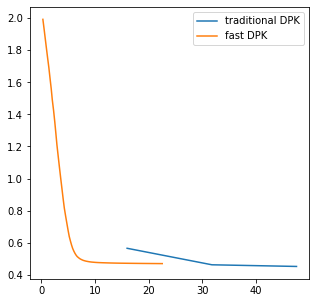

In [24]:
plt.figure(figsize=(5, 5))
plt.plot(dpk_times[:3], dpk_losses[:3], label="traditional DPK")
plt.plot(times, train_losses, label="fast DPK")
plt.legend()

In [ ]:
# pseudocode
dataset = []
def load():
    return
itrs = 10
def train():
    return

for bigbatch in dataset:
    data = load(bigbatch)
    for itr in range(itrs):
        train(data)

NN = 1
minibatches = []
def get_loss():
    return
optimizer = 1

def step():
    """do one step of gradient descent"""
    optimizer.zero_grad()  # begin new GD step
    possible_outputs = NN(inpts)
    for minibatch in minibatches:  # a minibatch is only a few timesteps
        loss = get_loss(possible_outputs, minibatch)
        loss.backward()  # add to gradient
    optimizer.step()

In [84]:
num_samples = 2 # 100
ws = torch.tensor(omegas)  # torch.linspace(0, 0.15, num_samples)
global_error = torch.empty((num_samples, num_samples), dtype=torch.complex64)
for i, w1 in enumerate(ws):
    for j, w2 in enumerate(ws):
        w = [w1, w2]
        print(w)
        ifft_coefs = torch.exp(complex("j") * (sum(F[i] * w[i] * num_samples for i in range(omega_dim))))
        global_error[i, j] = torch.sum(Lft * ifft_coefs) / num_samples  # TODO take only real part (imag should be near 0)
    

[tensor(0.0314), tensor(0.0314)]
[tensor(0.0314), tensor(0.1257)]
[tensor(0.1257), tensor(0.0314)]
[tensor(0.1257), tensor(0.1257)]


In [173]:
global_error

tensor([[36045.6797-33.4762j, 36136.5703-46.7841j],
        [35534.0547-120.4019j, 35621.5820-133.6497j]], grad_fn=<CopySlices>)

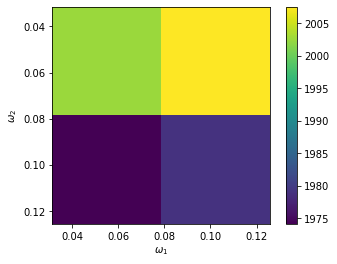

In [169]:
plt.imshow(np.real(global_error.detach().numpy()), extent=(ws[0], ws[-1], ws[-1], ws[0]))
plt.xlabel("$\omega_1$")
plt.ylabel("$\omega_2$")
plt.colorbar()

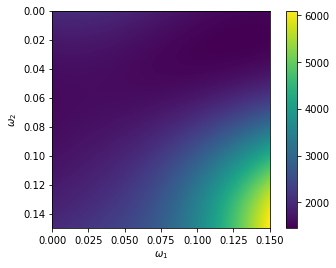

In [167]:
plt.imshow(np.real(global_error.detach().numpy()), extent=(ws[0], ws[-1], ws[-1], ws[0]))
plt.xlabel("$\omega_1$")
plt.ylabel("$\omega_2$")
plt.colorbar()

In [148]:
opt.zero_grad()
    
losses = torch.empty((K, x.shape[0]))

inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)  # todo: generalize to more omegas
#     inpts = torch.cat([torch.cos(two_pi_block)] + [torch.sin(two_pi_block)], -1)  # todo: generalize to more omegas
inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
y, z, a = model_obj.decode(inpts)
#     xhat, = model_obj.decode(inpts)
for tt in range(x.shape[0]):
    losses[:, tt] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
#         losses[:, tt] = (xhat.squeeze() - x[tt, :]) ** 2 / K

In [150]:
complex_losses = torch.stack([losses.T, zeros_like], -1)
losses_fft = torch.fft(complex_losses, signal_ndim=1)
E_ft = torch.zeros((losses.shape[0] * losses.shape[1], 2), dtype=torch.float64)
for t in range(1, losses.shape[1] + 1):
    E_ft[np.arange(K // 2) * t, :] += losses_fft[t-1, :K//2, :]  # what are the units of "frequency"? 1/idxs of E

In [156]:
E_ft.shape

torch.Size([23999, 2])

In [155]:
torch.sum(torch.isnan(E_ft))

tensor(312)

In [151]:
E_ft = torch.cat([E_ft, torch.flip(E_ft * torch.Tensor([[1, -1]]), dims=(0,))])[:-1]
E = torch.ifft(E_ft, signal_ndim=1)[:, 0]
omega_idx = int(np.round(omegas[0] * E.shape[0] / (2 * np.pi)))
E_star = E[omega_idx]
loss = E_star  # - E.mean()
print(loss.detach().numpy())

nan


In [134]:
params

(array([[ 1.2993203 ],
        [ 1.2936934 ],
        [ 1.2869567 ],
        [ 1.2791173 ],
        [ 1.2701837 ],
        [ 1.2601651 ],
        [ 1.2490717 ],
        [ 1.2369155 ],
        [ 1.2237092 ],
        [ 1.2094672 ],
        [ 1.1942054 ],
        [ 1.177941  ],
        [ 1.160693  ],
        [ 1.1424822 ],
        [ 1.1233308 ],
        [ 1.1032628 ],
        [ 1.0823044 ],
        [ 1.0604829 ],
        [ 1.0378276 ],
        [ 1.0143698 ],
        [ 0.990142  ],
        [ 0.96517813],
        [ 0.93951356],
        [ 0.9131855 ],
        [ 0.88623106],
        [ 0.8586893 ],
        [ 0.83059907],
        [ 0.8019998 ],
        [ 0.7729316 ],
        [ 0.74343395],
        [ 0.7135461 ],
        [ 0.68330663],
        [ 0.6527531 ],
        [ 0.62192214],
        [ 0.5908493 ],
        [ 0.55956805],
        [ 0.52811027],
        [ 0.4965062 ],
        [ 0.4647841 ],
        [ 0.4329698 ],
        [ 0.4010871 ],
        [ 0.36915794],
        [ 0.337202  ],
        [ 0

In [9]:
%matplotlib notebook
plt.figure(figsize=(12, 4))
plt.plot(E_ft.detach().numpy())
# plt.ylim([-12, 12])
plt.show()

<IPython.core.display.Javascript object>

In [87]:
opt.zero_grad()
    
losses = torch.empty((K, x.shape[0]))

In [88]:

inpts = torch.cat([torch.cos(two_pi_block)] * 3 + [torch.sin(two_pi_block)] * 3, -1)  # todo: generalize to more omegas
inpts  # [cos_mu_w1, cos_mu_w2, cos_sigma_w1, cos_sigma_w2, cos_alpha_w1, cos_alpha_w2, sin...]
y, z, a = model_obj.decode(inpts)
#     xhat, = model_obj.decode(inpts)
for tt in range(x.shape[0]):
    losses[:, tt] = ((x[tt, :] - y)**2 / (2 * z**2) + z.log() - norm_logcdf(a * (x[tt, :] - y) / z)).squeeze()
#         losses[:, tt] = (xhat.squeeze() - x[tt, :]) ** 2 / K


In [ ]:
# E = stitch together local errors using FFT
complex_losses = torch.stack([losses.T, zeros_like], -1)
losses_fft = torch.fft(complex_losses, signal_ndim=1)
E_ft = torch.zeros((losses.shape[0] * losses.shape[1], 2), dtype=torch.float64)
for t in range(1, losses.shape[1] + 1):
    E_ft[np.arange(K // 2) * t, :] += losses_fft[t-1, :K//2, :]  # what are the units of "frequency"? 1/idxs of E
E_ft = torch.cat([E_ft, torch.flip(E_ft * torch.Tensor([[1, -1]]), dims=(0,))])[:-1]
E = torch.ifft(E_ft, signal_ndim=1)[:, 0]
omega_idx = int(np.round(omegas[0] * E.shape[0] / (2 * np.pi)))
E_star = E[omega_idx]
loss = E_star  # - E.mean()
print(loss.detach().numpy())

In [107]:
def reconstruct(errors):
    e_fft = np.fft.fft(errors)
    E_ft = np.zeros(errors.shape[0]*K, dtype=np.complex64)

    for t in range(1,e_fft.shape[0]+1):
        E_ft[np.arange(K//2)*t] += e_fft[t-1,:K//2]

    E_ft = np.concatenate([E_ft, np.conj(np.flip(E_ft))])[:-1]
    E = np.real(np.fft.ifft(E_ft))
    return E, E_ft

In [102]:
losses.shape

torch.Size([12, 1000])

In [226]:
errors = losses.T.detach()
e_fft = np.fft.fft(errors)
EE_ft = np.zeros(errors.shape[0]*K, dtype=np.complex64)

for t in range(1,e_fft.shape[0]+1):
    EE_ft[np.arange(K//2)*t] += e_fft[t-1,:K//2]

EE_ft = np.concatenate([EE_ft, np.conj(np.flip(EE_ft))])[:-1]
EE = np.real(np.fft.ifft(EE_ft))

In [227]:
e_fft.shape, losses_fft.shape

((1000, 12), torch.Size([1000, 12, 2]))

In [229]:
EE_ft.shape, E_ft.shape

((23999,), torch.Size([24000, 2]))

In [222]:
EE, E

(array([0.60256482, 0.60867274, 0.62126004, ..., 0.63344935, 0.61528097,
        0.60463549]),
 tensor([2.5965, 2.6339, 2.7014,  ..., 2.7989, 2.7048, 2.6220],
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [10]:
%matplotlib notebook
plt.plot(E)

<IPython.core.display.Javascript object>

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [40]:
yy

tensor([0.3698], grad_fn=<AddBackward0>)

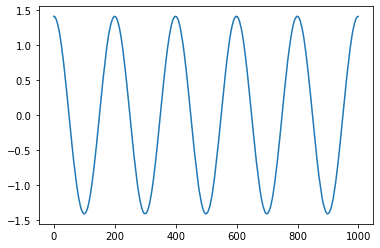

In [27]:
plt.plot(x)

In [14]:
model_obj

SkewNormalNLL(
  (l1_mu): Linear(in_features=2, out_features=32, bias=True)
  (l2_mu): Linear(in_features=32, out_features=64, bias=True)
  (l3_mu): Linear(in_features=64, out_features=1, bias=True)
  (l1_sig): Linear(in_features=2, out_features=32, bias=True)
  (l2_sig): Linear(in_features=32, out_features=64, bias=True)
  (l3_sig): Linear(in_features=64, out_features=1, bias=True)
  (l1_a): Linear(in_features=2, out_features=32, bias=True)
  (l2_a): Linear(in_features=32, out_features=64, bias=True)
  (l3_a): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
arr.shape

(1, 100, 2)

In [43]:
t = np.linspace(0, 2 * np.pi, 100)
arr = np.stack([np.cos(t) * 0] * 3 + [np.sin(t)] * 3).T
inpts = torch.Tensor(arr)
y, z, a = model_obj.decode(inpts)

<IPython.core.display.Javascript object>


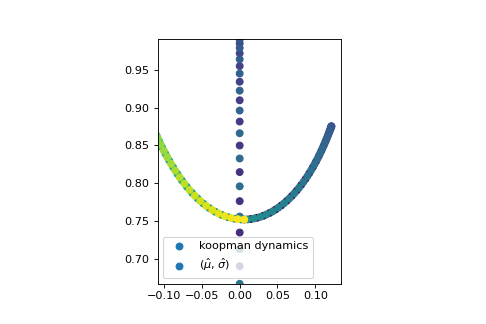

In [46]:
%matplotlib notebook
plt.scatter(arr[:, 0], arr[:, 3], c=t, label="koopman dynamics")
plt.scatter(y.detach(), z.detach(), c=t, label="($\hat \mu$, $\hat \sigma$)")
# plt.plot(arr, z.detach(), label="z")
# plt.plot(arr, a.detach(), label="a")
plt.legend()
plt.gca().set_aspect(1)

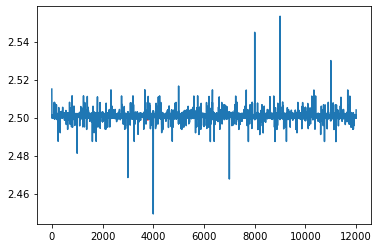

In [39]:
%matplotlib notebook
plt.plot(E.detach())
plt.scatter([omega_idx], [E_star.detach()], c="r", s=50)

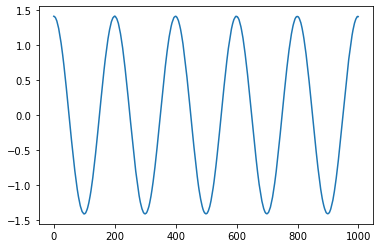

In [52]:
plt.plot(x)

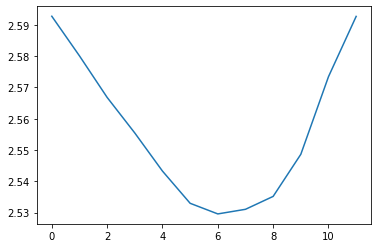

In [167]:
plt.plot(losses[:, 0].detach())  # when t=0 the loss should not depend on w, because wt = 0 for all w

In [ ]:
# plot
plt.plot(x_hat, "tab:orange", label="$\hat x$")
plt.plot(data, "tab:blue", label="$x$")
plt.plot(x_hat + std_hat, "--k", label="$\hat x \pm \hat \sigma$")
plt.plot(x_hat - std_hat, "--k")
plt.xlim([9_900, 10_100])
plt.legend()
plt.show()

plt.plot(mu_t, label="$\mu$")
plt.plot(x_hat, ":k", label="$\hat \mu$")
plt.plot(sigma_t, label="$\sigma$")
plt.plot(std_hat, "--k", label="$\hat \sigma$")
plt.xlim([50_900, 51_100])
plt.legend()
plt.show()

TypeError: linspace() got an unexpected keyword argument 'endpoint'

In [3]:
from numpy.fft import fftshift, ifftshift, ifftn, fftfreq, fftn, rfftn, irfftn

In [6]:
# Lft = np.array([range(i + 1, i + 4) for i in range(10, 90, 10)])

T = 10
K = 3
inpts = np.arange(K*T) * 2 * np.pi / (K * T)
mesh_t, mesh1, mesh2 = np.meshgrid(np.arange(1, T + 1), inpts, inpts, indexing="ij")
local_losses = np.exp(np.sin(mesh_t * (mesh1 + mesh2)))
L = np.array([local_losses[0, 0:K*T:T, 0:K*T:T] for t in range(1, T+1)])
Lft = fftshift(fftn(L, axes=(1, 2)), axes=(1, 2))  # if I don't do fftshift, I can think of the frequencies as n/N for n = 0:N-13 (not when doing zero padding)
Eft = np.zeros((T * K, T * K), dtype=complex)
for t in range(1, T + 1):
    # Eft[0:K*t:t, 0:K*t:t] += Lft[t - 1, :, :]
    # upper left quadrant
    Eft[0:(K//2)*t:t, 0:(K//2)*t:t] += Lft[t-1, :K//2, :K//2]
    # lower left quadrant
    Eft[(K//2)*t:K*t:t, 0:(K//2)*t:t] += Lft[t-1, K//2:K, :K//2]
    # upper right quadrant
    Eft[0:(K//2)*t:t, (K//2)*t:K*t:t] += Lft[t-1, :K//2, K//2:K]
    # lower right quadrant
    Eft[(K//2)*t:K*t:t, (K//2)*t:K*t:t] += Lft[t-1, K//2:K, K//2:K]

Text(0.5, 1.0, 'local loss')

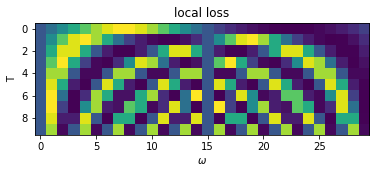

In [8]:
plt.imshow(local_losses[:, :, 0])
plt.xlabel("$\omega$")
plt.ylabel("T")
plt.title("local loss")

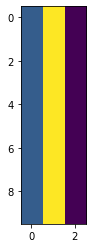

In [10]:
plt.imshow(L[:, :, 0])

In [30]:
actual_E = np.sum(local_losses, axis=0)

In [31]:
# M is a matrix you multiply by Lft to get E
losses = np.zeros((actual_E.shape), dtype=complex)
# each element is what freq is represented by the corresponding element in a 1D L
freqs = np.array([fftshift(fftfreq(K)) * t / T for t in range(1, T + 1)])
F0 = np.array([np.meshgrid(freqs[t], freqs[t], indexing="ij")[0] for t in range(T)])
F1 = np.array([np.meshgrid(freqs[t], freqs[t], indexing="ij")[1] for t in range(T)])
for i, w0 in enumerate(np.arange(K * T)):
    for j, w1 in enumerate(np.arange(K * T)):
        M = np.exp(complex("j") * 2 * np.pi * (F0 * w0 + F1 * w1))
        loss = np.sum(Lft * M) / K**2  # np.sum(np.prod(np.prod(L * M, axis=1), axis=1))
        losses[i, j] = loss

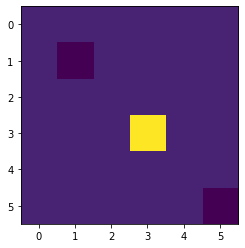

In [32]:
plt.imshow(np.real(Lft[0, :, :]))

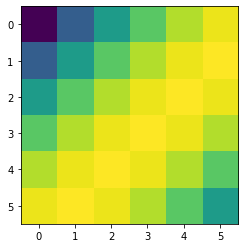

In [33]:
plt.imshow(np.real(M[0, :, :]))

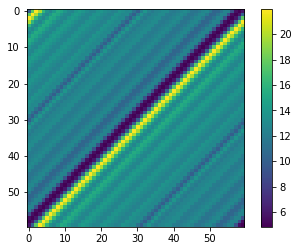

In [34]:
plt.imshow(np.real(losses))
plt.colorbar()

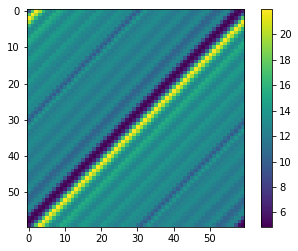

In [35]:
plt.imshow(np.real(actual_E))
plt.colorbar()

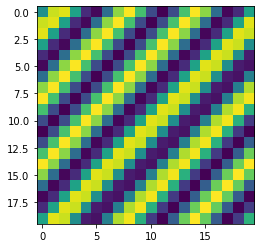

In [168]:
n = 20
x, y = np.meshgrid(np.arange(n), np.arange(n), indexing="ij")
s = np.sin(x + y)
plt.imshow(s)

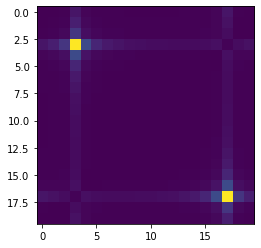

In [169]:
sft = fftn(s, axes=(0, 1))
plt.imshow(np.abs(sft))

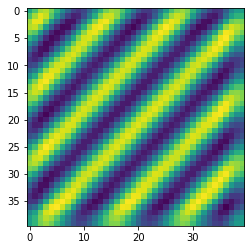

In [174]:
# whats the difference between them?
sft2 = np.zeros((2 * n, 2 * n), dtype=complex)
# sft2[:n, :n] = sft
sft2[0:n // 2, :n // 2] = sft[:n // 2, :n // 2]
sft2[-(n // 2):, -(n // 2):] = sft[-(n // 2):, -(n // 2):]
s2 = ifftn(sft2, axes=(0, 1))
plt.imshow(np.real(s2))

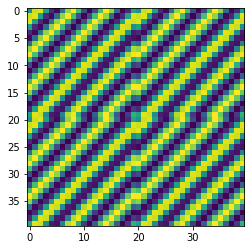

In [179]:
sft_dup = np.zeros((2 * n, 2 * n), dtype=complex)
sft_dup[::2, ::2] = sft
s_dup = ifftn(sft_dup, axes=(0, 1))
plt.imshow(np.real(s_dup))

# Try multidim FFT interpolation using torch.cos

In [2]:
from torch.fft import fftn, ifftn, fftshift, fftfreq

In [6]:
T = 20
K = 6
omega_dim = 2
w = [K * T // 2 for i in range(omega_dim)]

inpts = torch.arange(K*T, dtype=torch.float32, requires_grad=True) * 2 * np.pi / (K * T)
meshs = torch.meshgrid(torch.arange(1, T + 1, dtype=torch.float32), *(inpts for i in range(omega_dim)), indexing="ij")
mesh_t = meshs[0]
local_losses = torch.exp(torch.sin(mesh_t * (sum(meshs[1:]))))
global_losses = torch.sum(local_losses, axis=0)
L = torch.stack([local_losses.__getitem__((0, *(slice(0,K*T,T) for i in range(omega_dim)))) for t in range(1, T+1)])  # this only works for 2D rn

dims = tuple(range(-omega_dim, 0))
Lft = fftn(L, dim=dims)

In [ ]:
# M is a matrix you multiply by Lft to get E
losses = torch.zeros((global_losses.shape), dtype=torch.complex64)
# each element is what freq is represented by the corresponding element in a 1D L
freqs = torch.stack([fftfreq(K) * t / T for t in range(1, T + 1)])
F = []
for i in range(omega_dim):
    F.append(torch.stack([torch.meshgrid(*(freqs[t] for i in range(omega_dim)), indexing="ij")[0] for t in range(T)]))


# convert omega from the interval [0, 1] to [0, K*T]
for i, w0 in enumerate(torch.arange(K * T)):
    for j, w1 in enumerate(torch.arange(K * T)):
        w = [w0, w1, 30]
        M = torch.exp(complex("j") * 2 * np.pi * (sum(F[i] * w[i] for i in range(omega_dim))))
        loss = torch.sum(Lft * M) / K**omega_dim
        losses[i, j] = loss

In [7]:
loss, global_losses[K * T // 2, K * T // 2]

(tensor(20.0001+5.5715e-08j, grad_fn=<DivBackward0>),
 tensor(20.0000, grad_fn=<SelectBackward0>))

In [ ]:
plt.imshow(np.real(losses[:, :].detach().numpy()))
plt.colorbar()

Error: Session cannot generate requests

In [8]:
torch.real(losses[0, 0, 0]).backward()

IndexError: too many indices for tensor of dimension 2

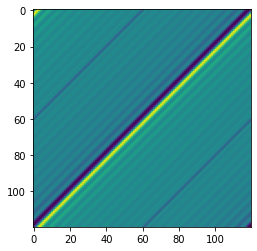

In [9]:
plt.imshow(global_losses[:, :].detach().numpy())